In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from gpflow.config import default_float
from typing import Tuple, Optional


In [11]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(tf.__version__)
print(tf.keras.__version__)
print(f'TF eager exectution: {tf.executing_eagerly()}')
print(f'GPU is available: {tf.test.is_gpu_available()}')
get_available_gpus()

2.0.0
2.2.4-tf
TF eager exectution: True
GPU is available: True


['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']

In [3]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

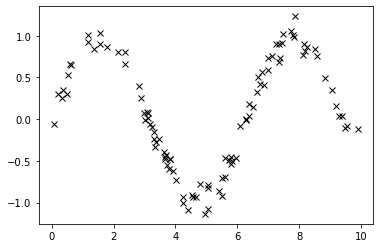

In [4]:
def noisy_sin(x): 
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())

num_train_data, num_test_data = 100, 500

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = noisy_sin(X)
Ytest = noisy_sin(Xtest)

data = (X, Y)

plt.plot(X, Y, 'xk')
plt.show()

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = num_train_data // 2
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = train_dataset.repeat()\
                    .prefetch(prefetch_size)\
                    .shuffle(buffer_size=shuffle_buffer_size)\
                    .batch(batch_size)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=50
shuffle_buffer_size=50
num_batches_per_epoch=3


In [6]:
kernel = gpflow.kernels.RBF(variance=2.)
likelihood = gpflow.likelihoods.Gaussian()
inducing_variable = np.linspace(0, 10, num_features).reshape(-1, 1)

model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable)

In [7]:
from gpflow.utilities import set_trainable

set_trainable(likelihood, False)
set_trainable(kernel.variance, False)

set_trainable(likelihood, True)
set_trainable(kernel.variance, True)

In [8]:
kernel.lengthscale.assign(0.5)

In [9]:
from gpflow.utilities import print_summary

print_summary(model)  # same as print_summary(model, fmt="simple")

name                      class      transform                prior    trainable    shape        dtype    value
------------------------  ---------  -----------------------  -------  -----------  -----------  -------  ----------------
SVGP.kernel.variance      Parameter  Softplus                          True         ()           float64  2.0
SVGP.kernel.lengthscale   Parameter  Softplus                          True         ()           float64  0.5
SVGP.likelihood.variance  Parameter  Softplus + AffineScalar           True         ()           float64  1.0
SVGP.inducing_variable.Z  Parameter                                    True         (10, 1)      float64  [[0....
SVGP.q_mu                 Parameter                                    True         (10, 1)      float64  [[0....
SVGP.q_sqrt               Parameter  FillTriangular                    True         (1, 10, 10)  float64  [[[1., 0., 0....


In [14]:
gpflow.config.set_default_summary_fmt("notebook")

print_summary(model)  # same as print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.0
SVGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.5
SVGP.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,0.9999999999999999
SVGP.inducing_variable.Z,Parameter,,,True,"(10, 1)",float64,[[0....
SVGP.q_mu,Parameter,,,True,"(10, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[1., 0., 0...."


In [15]:
optimizer = tf.optimizers.Adam()

with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    obj = - model.elbo(data)
    grads = tape.gradient(obj, model.trainable_variables)
    
optimizer.apply_gradients(zip(grads, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [18]:
def optimization_step(model: gpflow.models.SVGP, batch: Tuple[tf.Tensor, tf.Tensor]):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        obj = - model.elbo(batch)
        grads = tape.gradient(obj, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [19]:
def simple_training_loop(model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
    batches = iter(train_dataset)
    tf_optimization_step = tf.function(optimization_step, autograph=False)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            tf_optimization_step(model, next(batches))

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

In [20]:
simple_training_loop(model, epochs=10, logging_epoch_freq=2)


Epoch 2: ELBO (train) -213.1563929531547
Epoch 4: ELBO (train) -211.45823206069403
Epoch 6: ELBO (train) -209.74744207761347
Epoch 8: ELBO (train) -208.025304570418
Epoch 10: ELBO (train) -206.30014463627805
